In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import os

In [2]:
file_path = os.path.join('Resources', 'charity_data.csv')

In [3]:
charity_df = pd.read_csv(file_path)
charity_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## Exploration and Preprocessing

In [4]:
# Explore objects in data set
# First pull objects index for each column and save to list
categories = charity_df.dtypes[(charity_df.dtypes == 'object') | (charity_df.dtypes == 'int64')].index.tolist()

# Use list of object indexes to indentify unique values in charity_df
charity_df[categories].nunique()

EIN                       34299
NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [5]:
charity_df.dtypes

EIN                        int64
NAME                      object
APPLICATION_TYPE          object
AFFILIATION               object
CLASSIFICATION            object
USE_CASE                  object
ORGANIZATION              object
STATUS                     int64
INCOME_AMT                object
SPECIAL_CONSIDERATIONS    object
ASK_AMT                    int64
IS_SUCCESSFUL              int64
dtype: object

Exploring the data:
- EIN - will be used as index
- NAME - copy to new df keeping EIN as index and drop name column in charity_df.
- APPLICATION_TYPE - explore to identify whether the data can be combined.
- AFFILIATION - check values
- CLASSIFICATION - ascertain whether specific classifications can be grouped.
- USE_CASE - identify use cases to determin validity of dimension.
- ORGANIZATION - Identify organizations and validate whether dimension is required.
- STATUS - Drop applications with active status since outcome will no be known and may skew training/testing data.
- INCOME_AMT 
- SPECIAL CONSIDERATIONS -  explore further...could be changed to boolean instead of y/n, however, firther analysis required to ascertain whether it can be dropped all together.
- ASK_AMT - check for null values.
- IS_SUCCESSFUL - target already boolen - need to identify which boolean represents succssful use of money.

### EIN

In [6]:
# Check counts
charity_df.count()

EIN                       34299
NAME                      34299
APPLICATION_TYPE          34299
AFFILIATION               34299
CLASSIFICATION            34299
USE_CASE                  34299
ORGANIZATION              34299
STATUS                    34299
INCOME_AMT                34299
SPECIAL_CONSIDERATIONS    34299
ASK_AMT                   34299
IS_SUCCESSFUL             34299
dtype: int64

In [7]:
# Check number of unique values
charity_df['EIN'].nunique()

34299

In [8]:
# Double check for duplicates before making EIN index
charity_df['EIN'].duplicated().sum()

0

In [9]:
# Set EIN as index
charity_df = charity_df.set_index('EIN')

In [10]:
# Check index
charity_df.head()

,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,,,
10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### NAME

In [11]:
# Create name_df so it can be added back to dataset later if needed
name_df = pd.DataFrame(charity_df['NAME'])

In [12]:
# Verify index was changed
name_df.head(3)

,NAME
EIN,
10520599,BLUE KNIGHTS MOTORCYCLE CLUB
10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR
10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS


In [13]:
charity_df = charity_df.drop('NAME', axis=1)
charity_df.head(1)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,,
10520599,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1


### APPLICATION TYPE

In [14]:
# Check number of times each application type appears
application_value_count = charity_df['APPLICATION_TYPE'].value_counts()
print(application_value_count)

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64


In [15]:
app_val_dict = dict(application_value_count)
print(app_val_dict)

{'T3': 27037, 'T4': 1542, 'T6': 1216, 'T5': 1173, 'T19': 1065, 'T8': 737, 'T7': 725, 'T10': 528, 'T9': 156, 'T13': 66, 'T12': 27, 'T2': 16, 'T25': 3, 'T14': 3, 'T29': 2, 'T15': 2, 'T17': 1}


In [16]:
# Create list of application types with over 500 values
key_list = []
for k, v in app_val_dict.items():
    if v > 500:
        key_list.append(k)
print(key_list)

['T3', 'T4', 'T6', 'T5', 'T19', 'T8', 'T7', 'T10']


In [17]:
# Drop application types with less than 500 values using key_list
charity_df = charity_df.loc[charity_df['APPLICATION_TYPE'].isin(key_list)]

In [18]:
# Apply new 'Other' bin to 
#for application_type in key_list:
#   charity_df.APPLICATION_TYPE = charity_df.APPLICATION_TYPE.replace(application_type, 'Other')

In [19]:
# Check values
charity_df['APPLICATION_TYPE'].value_counts()

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
Name: APPLICATION_TYPE, dtype: int64

In [20]:
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,,
10520599,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
10531628,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
10547893,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
10553066,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
10556103,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


### AFFILIATION

In [21]:
# Save affiliation value counts to dictionary
affiliation_value_dict = dict(charity_df['AFFILIATION'].value_counts())
print(affiliation_value_dict)

{'Independent': 18210, 'CompanySponsored': 15702, 'Family/Parent': 64, 'National': 31, 'Regional': 12, 'Other': 4}


In [22]:
aff_key_list = []

for k,v in affiliation_value_dict.items():
    if v > 1000:
        aff_key_list.append(k)

print(aff_key_list)        

['Independent', 'CompanySponsored']


In [23]:
# Drop application types with less than 500 values using key_list
charity_df = charity_df.loc[charity_df['AFFILIATION'].isin(aff_key_list)]

In [24]:
# Check values
charity_df['AFFILIATION'].value_counts()

Independent         18210
CompanySponsored    15702
Name: AFFILIATION, dtype: int64

### CLASSIFICATION

In [25]:
# Check values of unique classifications
class_count = dict(charity_df['CLASSIFICATION'].value_counts())
print(class_count)

{'C1000': 17016, 'C2000': 6023, 'C1200': 4824, 'C3000': 1917, 'C2100': 1881, 'C7000': 772, 'C1700': 286, 'C4000': 193, 'C5000': 116, 'C1270': 114, 'C2700': 104, 'C2800': 94, 'C7100': 75, 'C1300': 58, 'C1280': 50, 'C1230': 36, 'C1400': 34, 'C2300': 32, 'C7200': 32, 'C1240': 30, 'C7120': 18, 'C8000': 18, 'C1500': 16, 'C6000': 15, 'C1800': 15, 'C1250': 14, 'C8200': 11, 'C1278': 10, 'C1238': 10, 'C1235': 9, 'C1237': 9, 'C7210': 7, 'C1720': 6, 'C4100': 6, 'C2400': 6, 'C1257': 5, 'C1600': 5, 'C1260': 3, 'C2710': 3, 'C0': 3, 'C3200': 2, 'C1267': 2, 'C1256': 2, 'C1234': 2, 'C1246': 2, 'C1283': 1, 'C1900': 1, 'C2170': 1, 'C5200': 1, 'C1370': 1, 'C1820': 1, 'C4500': 1, 'C1248': 1, 'C4200': 1, 'C4120': 1, 'C1245': 1, 'C1236': 1, 'C2561': 1, 'C3700': 1, 'C2500': 1, 'C2570': 1, 'C2150': 1, 'C1570': 1, 'C2600': 1, 'C2380': 1, 'C1580': 1, 'C1732': 1, 'C2190': 1, 'C8210': 1, 'C1728': 1, 'C6100': 1}


In [26]:
c_count = charity_df['CLASSIFICATION'].value_counts()
#charity_df = charity_df.drop('CLASSIFICATION', axis=1)

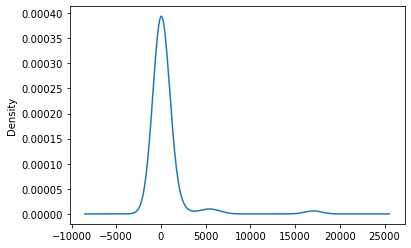

In [27]:
c_count.plot.density()

In [28]:
key_list = []

for k,v in class_count.items():
    if v < 1000:
        key_list.append(k)

print(key_list)

['C7000', 'C1700', 'C4000', 'C5000', 'C1270', 'C2700', 'C2800', 'C7100', 'C1300', 'C1280', 'C1230', 'C1400', 'C2300', 'C7200', 'C1240', 'C7120', 'C8000', 'C1500', 'C6000', 'C1800', 'C1250', 'C8200', 'C1278', 'C1238', 'C1235', 'C1237', 'C7210', 'C1720', 'C4100', 'C2400', 'C1257', 'C1600', 'C1260', 'C2710', 'C0', 'C3200', 'C1267', 'C1256', 'C1234', 'C1246', 'C1283', 'C1900', 'C2170', 'C5200', 'C1370', 'C1820', 'C4500', 'C1248', 'C4200', 'C4120', 'C1245', 'C1236', 'C2561', 'C3700', 'C2500', 'C2570', 'C2150', 'C1570', 'C2600', 'C2380', 'C1580', 'C1732', 'C2190', 'C8210', 'C1728', 'C6100']


In [29]:
# Apply new 'Other' bin to 
for classification in key_list:
    charity_df.CLASSIFICATION = charity_df.CLASSIFICATION.replace(classification, 'Other')

In [30]:
charity_df['CLASSIFICATION'].value_counts()

C1000    17016
C2000     6023
C1200     4824
Other     2251
C3000     1917
C2100     1881
Name: CLASSIFICATION, dtype: int64

### USE_CASE

In [31]:
use_case_list = charity_df['USE_CASE'].unique()
print(use_case_list)

['ProductDev' 'Preservation' 'Heathcare' 'CommunityServ' 'Other']


In [32]:
use_case_count = charity_df['USE_CASE'].value_counts()
print(use_case_count)

Preservation     27941
ProductDev        5443
CommunityServ      382
Heathcare          143
Other                3
Name: USE_CASE, dtype: int64


- Bin CommunityServ, Healthcare, other

In [33]:
# Group USE_CASES 'Heathcare', 'CommunityServ', 'Other' into bin named 'Other'
use_case_bin = list(use_case_count[use_case_count < 6000].index)

In [34]:
print(use_case_bin)

['ProductDev', 'CommunityServ', 'Heathcare', 'Other']


In [35]:
# Apply new 'Other' bin to 
for case in use_case_bin:
    charity_df.USE_CASE = charity_df.USE_CASE.replace(case, 'Other')    

In [36]:
# Drop application types with less than 150 values using key_list
#charity_df = charity_df.loc[charity_df['USE_CASE'].isin(use_case_bin)]

In [37]:
charity_df.USE_CASE.value_counts()

Preservation    27941
Other            5971
Name: USE_CASE, dtype: int64

In [38]:
# Check bins
use_case_count = charity_df['USE_CASE'].value_counts()
print(use_case_count)

Preservation    27941
Other            5971
Name: USE_CASE, dtype: int64


### ORGANIZATION

In [39]:
organization_list = charity_df['ORGANIZATION'].unique()
print(organization_list)

['Association' 'Co-operative' 'Trust' 'Corporation']


In [40]:
organization_list = dict(charity_df['ORGANIZATION'].value_counts())
print(organization_list)

{'Trust': 23313, 'Association': 10227, 'Co-operative': 332, 'Corporation': 40}


In [41]:
# Group USE_CASES 'Heathcare', 'CommunityServ', 'Other' into bin named 'Other'

charity_df.ORGANIZATION = charity_df.ORGANIZATION.replace(['Co-operative', 'Corporation'], 'Other')
#charity_df.ORGANIZATION = charity_df.ORGANIZATION.replace('Corporation', 'Association')

organization_list = dict(charity_df['ORGANIZATION'].value_counts())
print(organization_list)

{'Trust': 23313, 'Association': 10227, 'Other': 372}


### STATUS

In [42]:
charity_df.loc[charity_df['STATUS'] == 0]

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,,
205559542,T3,CompanySponsored,C2000,Other,Trust,0,0,N,5000,1
205918776,T3,Independent,C1000,Preservation,Trust,0,25000-99999,Y,7287,1
330970564,T3,Independent,C1000,Preservation,Trust,0,10000-24999,N,5000,1
510594485,T3,CompanySponsored,C2100,Other,Association,0,0,N,5000,0
841164329,T3,Independent,C1000,Preservation,Association,0,0,N,5000,0


In [43]:
charity_df.STATUS.value_counts()

1    33907
0        5
Name: STATUS, dtype: int64

- drop status as its difficult to draw any meaning from category

In [44]:
charity_df = charity_df.drop('STATUS', axis=1)

In [45]:
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,,
10520599,T10,Independent,C1000,Other,Association,0,N,5000,1
10531628,T3,Independent,C2000,Preservation,Other,1-9999,N,108590,1
10547893,T5,CompanySponsored,C3000,Other,Association,0,N,5000,0
10553066,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,N,6692,1
10556103,T3,Independent,C1000,Other,Trust,100000-499999,N,142590,1


### SPECIAL CONSIDERATIONS

In [46]:
charity_df['SPECIAL_CONSIDERATIONS'].value_counts()

N    33885
Y       27
Name: SPECIAL_CONSIDERATIONS, dtype: int64

- drop special considerations

In [47]:
charity_df = charity_df.drop('SPECIAL_CONSIDERATIONS', axis=1)

In [48]:
charity_df.head(5)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
EIN,,,,,,,,
10520599,T10,Independent,C1000,Other,Association,0,5000,1
10531628,T3,Independent,C2000,Preservation,Other,1-9999,108590,1
10547893,T5,CompanySponsored,C3000,Other,Association,0,5000,0
10553066,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,6692,1
10556103,T3,Independent,C1000,Other,Trust,100000-499999,142590,1


### ASK_AMT

In [49]:
unique_list = charity_df['ASK_AMT'].unique()

In [50]:
len(unique_list)

8489

In [51]:
charity_df['ASK_AMT'].value_counts()

5000       25272
6725           3
63981          3
15583          3
10478          3
           ...  
806737         1
266679         1
59848          1
772556         1
1138700        1
Name: ASK_AMT, Length: 8489, dtype: int64

In [52]:
ask_amounts = dict(charity_df['ASK_AMT'].value_counts())

In [53]:
bin_list = []
five = []
two_fifty = []
five_hundred = []
seven_fifty = []
mill = []
mill_two_fifty = []

for key in ask_amounts.keys():
    if key == 5000:
        five.append(k)
    elif key in range(5001, 250000):
        two_fifty.append(key)
    elif key in range(250000, 500000):
        five_hundred.append(key)
    elif key in range(500000, 1000000):
        mill.append(key)
    else:
        mill_two_fifty.append(key)

In [54]:
get_len = [five, two_fifty, five_hundred, seven_fifty, mill, mill_two_fifty]

In [55]:
print(len(five))
print(len(two_fifty))
print(len(five_hundred))
print(len(seven_fifty))
print(len(mill))
print(len(mill_two_fifty))

1
5585
838
0
622
1443


In [56]:
charity_df.ASK_AMT = charity_df['ASK_AMT'].replace(two_fifty, 250000)
charity_df.ASK_AMT = charity_df['ASK_AMT'].replace(five_hundred, 500000)
charity_df.ASK_AMT = charity_df['ASK_AMT'].replace(mill, 1000000)
charity_df.ASK_AMT = charity_df['ASK_AMT'].replace(mill_two_fifty, 1250000)

In [57]:
charity_df['ASK_AMT'].value_counts()

5000       25272
250000      5735
1000000     1461
1250000     1444
Name: ASK_AMT, dtype: int64

In [58]:
charity_df['ASK_AMT'].head()

EIN
10520599      5000
10531628    250000
10547893      5000
10553066    250000
10556103    250000
Name: ASK_AMT, dtype: int64

### INCOME_AMT

In [59]:
charity_df['INCOME_AMT'].value_counts()

0                24268
25000-99999       3702
100000-499999     3317
1M-5M              897
1-9999             715
10000-24999        532
10M-50M            205
5M-10M             157
50M+               119
Name: INCOME_AMT, dtype: int64

In [60]:
one_to_twentyfive = ['1-9999', '10000-24999']
five_to_fifty = ['1M-5M','5M-10M', '10M-50M', '50M+']
charity_df.INCOME_AMT = charity_df['INCOME_AMT'].replace(one_to_twentyfive, '1-24999')
charity_df.INCOME_AMT = charity_df['INCOME_AMT'].replace(five_to_fifty, '5M-50M+')
charity_df['INCOME_AMT'].value_counts()

0                24268
25000-99999       3702
100000-499999     3317
5M-50M+           1378
1-24999           1247
Name: INCOME_AMT, dtype: int64

### Encoding Data

In [61]:
charity_df.dtypes

APPLICATION_TYPE    object
AFFILIATION         object
CLASSIFICATION      object
USE_CASE            object
ORGANIZATION        object
INCOME_AMT          object
ASK_AMT              int64
IS_SUCCESSFUL        int64
dtype: object

In [62]:
cat_charity = charity_df.dtypes[charity_df.dtypes == 'object'].index.tolist()
is_successful = 'IS_SUCCESSFUL'
ask = 'ASK_AMT'
cat_charity.append(is_successful)
cat_charity.append(ask)

In [63]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(charity_df[cat_charity]))

# Set index to match charity_df index
encode_df = encode_df.set_index(charity_df.index)

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(cat_charity)
encode_df.head()

,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Independent,...,INCOME_AMT_1-24999,INCOME_AMT_100000-499999,INCOME_AMT_25000-99999,INCOME_AMT_5M-50M+,IS_SUCCESSFUL_0,IS_SUCCESSFUL_1,ASK_AMT_5000,ASK_AMT_250000,ASK_AMT_1000000,ASK_AMT_1250000
EIN,,,,,,,,,,,,,,,,,,,,,
10520599,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10531628,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10547893,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
10553066,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10556103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [64]:
# Merge one-hot encoded features and drop the originals
charity_df = charity_df.merge(encode_df,left_index=True, right_index=True)
charity_df.head(3)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,...,INCOME_AMT_1-24999,INCOME_AMT_100000-499999,INCOME_AMT_25000-99999,INCOME_AMT_5M-50M+,IS_SUCCESSFUL_0,IS_SUCCESSFUL_1,ASK_AMT_5000,ASK_AMT_250000,ASK_AMT_1000000,ASK_AMT_1250000
EIN,,,,,,,,,,,,,,,,,,,,,
10520599,T10,Independent,C1000,Other,Association,0,5000,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10531628,T3,Independent,C2000,Preservation,Other,1-24999,250000,1,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10547893,T5,CompanySponsored,C3000,Other,Association,0,5000,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [65]:
charity_df = charity_df.drop(cat_charity, axis=1)
charity_df.head()

,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,AFFILIATION_Independent,...,INCOME_AMT_1-24999,INCOME_AMT_100000-499999,INCOME_AMT_25000-99999,INCOME_AMT_5M-50M+,IS_SUCCESSFUL_0,IS_SUCCESSFUL_1,ASK_AMT_5000,ASK_AMT_250000,ASK_AMT_1000000,ASK_AMT_1250000
EIN,,,,,,,,,,,,,,,,,,,,,
10520599,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10531628,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10547893,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
10553066,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
10556103,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [66]:
charity_df.count()

APPLICATION_TYPE_T10            33912
APPLICATION_TYPE_T19            33912
APPLICATION_TYPE_T3             33912
APPLICATION_TYPE_T4             33912
APPLICATION_TYPE_T5             33912
APPLICATION_TYPE_T6             33912
APPLICATION_TYPE_T7             33912
APPLICATION_TYPE_T8             33912
AFFILIATION_CompanySponsored    33912
AFFILIATION_Independent         33912
CLASSIFICATION_C1000            33912
CLASSIFICATION_C1200            33912
CLASSIFICATION_C2000            33912
CLASSIFICATION_C2100            33912
CLASSIFICATION_C3000            33912
CLASSIFICATION_Other            33912
USE_CASE_Other                  33912
USE_CASE_Preservation           33912
ORGANIZATION_Association        33912
ORGANIZATION_Other              33912
ORGANIZATION_Trust              33912
INCOME_AMT_0                    33912
INCOME_AMT_1-24999              33912
INCOME_AMT_100000-499999        33912
INCOME_AMT_25000-99999          33912
INCOME_AMT_5M-50M+              33912
IS_SUCCESSFU

### Scaling the Data

In [67]:
# Assign preprocessed data to features and target arrays
y = charity_df[['IS_SUCCESSFUL_0', 'IS_SUCCESSFUL_1']]
X = charity_df.drop(['IS_SUCCESSFUL_0', 'IS_SUCCESSFUL_1'], axis=1)

# Split train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2, stratify=y)

# Initiate scaler instance
scaler = StandardScaler()

# Fit data to scaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [68]:
len(X_train_scaled[0])

30

In [90]:
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer64 = 64
hidden_nodes_layer32 = 32
hidden_nodes_layer16 = 16
hidden_nodes_layer8 = 8
hidden_nodes_layer4 = 4
hidden_nodes_layer34 = 34
hidden_nodes_layer4

# Initialize keras sequential model object 
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer64, input_dim=number_input_features, activation="elu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer32, activation="elu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer16, activation="elu"))






# Output layer
nn.add(tf.keras.layers.Dense(units=2, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights every 100 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=2543400)

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50,callbacks=[cp_callback])

Train on 27129 samples
Epoch 1/50
27129/27129 [==============================] - 2s 69us/sample - loss: 0.5688 - accuracy: 0.7199
Epoch 2/50
27129/27129 [==============================] - 1s 52us/sample - loss: 0.5574 - accuracy: 0.7264
Epoch 3/50
27129/27129 [==============================] - 1s 43us/sample - loss: 0.5551 - accuracy: 0.7275
Epoch 4/50
27129/27129 [==============================] - 1s 48us/sample - loss: 0.5537 - accuracy: 0.7286
Epoch 5/50
27129/27129 [==============================] - 1s 42us/sample - loss: 0.5522 - accuracy: 0.7281
Epoch 6/50
27129/27129 [==============================] - 1s 43us/sample - loss: 0.5512 - accuracy: 0.7304
Epoch 7/50
27129/27129 [==============================] - 1s 43us/sample - loss: 0.5510 - accuracy: 0.7289
Epoch 8/50
27129/27129 [==============================] - 1s 43us/sample - loss: 0.5499 - accuracy: 0.7294
Epoch 9/50
27129/27129 [==============================] - 1s 42us/sample - loss: 0.5495 - accuracy: 0.7305
Epoch 10/50
27

In [87]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

6783/6783 - 0s - loss: 0.5410 - accuracy: 0.7364
Loss: 0.5410127555060383, Accuracy: 0.7363998293876648


In [ ]:
nn.summary()

In [ ]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
history_df.plot(y="loss")

In [ ]:
# Export our model to HDF5 file
nn.save("models/trained_minus_strat.h5")